# CS211: Data Privacy
## In-Class Exercise, Week of 10/03/2022

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon) for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

## Question 1

How do the Laplace and Gaussian mechanisms compare in terms of relative error on the query "how many individuals are over 50 years old" with $\epsilon = 1$ and $\delta = 10^{-5}$?

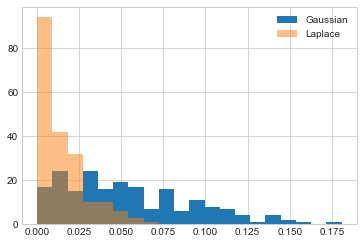

In [3]:
true_answer = len(adult[adult['Age'] > 50])

laplace_answers = [laplace_mech(true_answer, 1, 1) for _ in range(200)]
gaussian_answers = [gaussian_mech(true_answer, 1, 1, 10e-5) for _ in range(200)]

laplace_error = [pct_error(true_answer, a) for a in laplace_answers]
gaussian_error = [pct_error(true_answer, a) for a in gaussian_answers]

_, bins, _ = plt.hist(gaussian_error, bins=20, label='Gaussian')
plt.hist(laplace_error, bins=bins, label='Laplace', alpha=0.5)
plt.legend();

For queries with a single real number, the laplace mechanism gives better accuracy than the gaussian mechanism, and also gives a stronger prrivacy guarantee

## Question 2

The function `age_cdf` calculates the cumulative distribution function (CDF) of the ages in the adult dataset, expressed as a vector of counts.

What is the **L1 global sensitivity** of `age_cdf`?

Length of CDF vector: 100


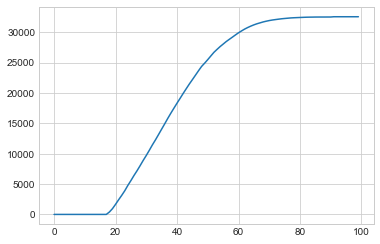

In [4]:
def age_cdf():
    a = adult['Age']
    return [len(a[a < i]) for i in range(100)]

plt.plot(age_cdf());
print('Length of CDF vector:', len(age_cdf()))

Each element of an vector is a counting query, so each element has a sensitivity of 1.
L1 sensitivity of the query is the sum of the individual sensitivities of the elements.
For this query, the L1 sensitivity is the sum of 100 1s
Total L1 sensitivity is 100*1 =100

## Question 3

What is the **L2 global sensitivity** of `age_cdf`?

- Find the sensitivity for each element of the vector(eg.1)
- Square the sensitivity for each element of the vector 
- Add up the squares (100(1*1) = 100)

- The L2 global sensitivity is the square root of the sum of the squares of the element-wise sensitivities
- Each element of the vector is a count, so it has a sensitivity of 1 and a squared sensitivity of `1*1 = 1`
- Thus the L2 global sensitivity is sqrt(100) = 10
- This is **much less** than the L1 sensitivity of 100

## Question 4

Use the vector-valued Laplace and Gaussian mechanisms to construct noisy versions of the CDF of ages. **Be sure to use the right sensitivity!**

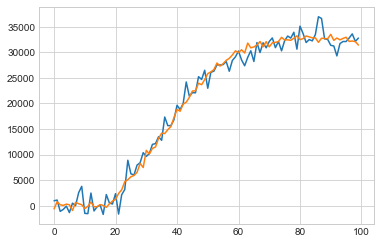

In [8]:
def laplace_cdf(epsilon):
    cdf = age_cdf()
    noisy_cdf = laplace_mech_vec(cdf, 100, epsilon) # L1 sensitivity
    return noisy_cdf

def gaussian_cdf(epsilon, delta):
    cdf = age_cdf()
    noisy_cdf = gaussian_mech_vec(cdf, 10, epsilon, delta) # L2 sensitivity
    return noisy_cdf

plt.plot(laplace_cdf(0.1));
plt.plot(gaussian_cdf(0.1, 1e-5));

## Question 5

Write a function to calculate the L1 **local sensitivity** of the following mean query.

In [ ]:
def mean_query():
    b = 125
    return adult['Age'][adult['Education'] == 'Bachelors'].clip(lower=0, upper=b).mean()

mean_query()

In [ ]:
def mean_query_local_sensitivity():
    b = 125
    n = len(adult['Age'][adult['Education'] == 'Bachelors'])
    sensitivity = b/(n+1)
    return sensitivity

mean_query_local_sensitivity()

In [ ]:
# TEST CASE
assert (mean_query_local_sensitivity() - 0.02333831217326363) < 0.0001

## Question 6

Why can't we use the local sensitivity from question 1 directly to achieve differential privacy for `mean_query`?

We cannot use local sensitivity from question 1 directly it is based on the data and in this case would reveal n.

## Question 7

Implement an upper bound on $A(f, x, k)$, the local sensitivity of a mean query at distance $k$.

In [ ]:
def ls_mean_at_distance(df, b, k):
    n = len(df)
    ls = b/(n+1)
    new_ls = b/((n+1)-k)
    return new_ls

In [ ]:
# TEST CASE
assert ls_mean_at_distance(adult['Age'], 125, 500) == 0.0038988178784192633
assert ls_mean_at_distance(adult['Age'], 125, 5000) == 0.004535394216465295

## Question 8

Implement an upper bound on $D(f, x, s)$, the distance from $x$ to a database where the local sensitivity of the mean query is greater than or equal to $s$.

In [ ]:
def dist_to_high_ls_mean(df, b, s):
    
    while 

In [ ]:
# TEST CASE
assert dist_to_high_ls_mean(adult['Age'], 125, 0.1) == 31311 
assert dist_to_high_ls_mean(adult['Age'], 125, 0.01) == 20061
assert dist_to_high_ls_mean(adult['Age'], 125, 0.001) == 0

## Question 9

Use the Propose-Test-Release (PTR) framework to calculate the mean age in the adult dataset with differential privacy.

In [ ]:
def mean_ptr(epsilon, delta):
    # YOUR CODE HERE
    raise NotImplementedError()

mean_ptr(1.0, 10e-5)

In [ ]:
# TEST CASE

true_answer = adult['Age'].mean()
trials = [mean_ptr(1.0, 10e-5) for _ in range(20)]
errors = [pct_error(true_answer, x) for x in trials]
assert np.mean(errors) < 1.0

## Exploration: how low can the proposal be?

In [ ]:
xs = np.linspace(0.001, 0.01)
clipped_ages = adult['Age'].clip(lower=0, upper=125)
ys = [dist_to_high_ls_mean(clipped_ages, 125, p) for p in xs]

In [ ]:
plt.plot(xs, ys)